In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata
import scipy.cluster.hierarchy as shc
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import scipy.spatial as spatial
from sklearn.metrics import pairwise_distances
from collections import Counter
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import timedelta

In [19]:
df = pd.read_pickle('output/enriched_data.pkl')
df['TEAM_MAGDA'] = df[['S', 'V', 'C', 'MP']].sum(axis = 1)
df['TEAM_UFFE'] = df[['M', 'SD', 'L', 'KD']].sum(axis = 1)
for p in ['S', 'SD', 'M', 'V', 'C', 'KD', 'MP', 'L']:
    df[p + '_'] = df[p] - df[p].mean()
df['STÖRSTA_PARTI_ADJUSTED'] = df[['S_', 'SD_', 'M_', 'V_', 'C_', 'KD_', 'MP_', 'L_']].idxmax(axis=1)
df['STÖRSTA_BLOCK'] = df[['TEAM_MAGDA', 'TEAM_UFFE']].idxmax(axis=1)
df['ORTSTYP'] = df.deso.str[4]
scaler = StandardScaler()
non_model_variables = ['deso',
                        'kommun', 'kommunnamn', 'lan',
                        'index_right', 'Lkfv', 'Vdnamn',
                        'Distriktkod', 'Distriktnamn', 'ORTSTYP',
                        'S', 'SD', 'M', 'V', 'C', 'KD', 'MP', 'L',
                        'S_', 'SD_', 'M_', 'V_', 'C_', 'KD_', 'MP_', 'L_',
                        'STÖRSTA_PARTI', 'STÖRSTA_PARTI_ADJUSTED',
                        'TEAM_MAGDA', 'TEAM_UFFE']
y = df['STÖRSTA_BLOCK']
df.set_index(['STÖRSTA_BLOCK', 'lannamn'], inplace = True)
X = df.drop(non_model_variables, axis = 1)
X = pd.DataFrame(data = scaler.fit_transform(X), index = X.index, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)


In [5]:
# Fitting SVM for reference model
param_grid = {
    "pca__n_components": [0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
    "svc__C": np.linspace(0.1,10,20),
    "svc__kernel": ['rbf',],
    "svc__gamma": ['auto'],
}
svc = SVC()
pca = PCA()
pipe = Pipeline([('pca', pca), ('svc',svc)])
search = GridSearchCV(pipe, param_grid, n_jobs=2, verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
y_hat = search.predict(X_test)
counter = 0
for i,j in zip(y_test.values, y_hat):
    if i == j:
        counter += 1
    else:
        pass

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameter (CV score=0.806):
{'pca__n_components': 0.99, 'svc__C': 3.2263157894736847, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


In [6]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print(counter/len(y_test))

Best parameter (CV score=0.806):
{'pca__n_components': 0.99, 'svc__C': 3.2263157894736847, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
0.8053467000835421


In [7]:
#linkage_list = ['single', 'average', 'complete', 'ward']
linkage_list = ['single']
distance_list = ['euclidean']
time_series = {}
for dist in distance_list:
    time_series[dist] = {}
    for link in linkage_list:
        indicator = False
        i = 0
        time_series[dist][link] = {}
        while indicator == False:
            temp = fclusterdata(X, i, criterion = 'distance', metric = dist, method = link)
            time_series[dist][link][i] = temp
            i += 1
            if (len(np.unique(temp)) == 1) or (i == len(X)):
                indicator = True

In [8]:
for dist in distance_list:
    for link in linkage_list:
        max_height = (np.max(list(time_series[dist][link])))
        for i in range(0, max_height+1):
            print(time_series[dist][link][i])

[2494 3169 5087 ... 5668 5421 5927]
[2494 3169 5087 ... 5668 5421 5927]
[2492 3167 5085 ... 5666 5419 5925]
[1334 1334 2914 ... 3495 3248 3754]
[119 119 119 ... 238 119 497]
[50 50 50 ... 50 50 69]
[29 29 29 ... 29 29 29]
[5 5 5 ... 5 5 5]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [21]:
# Converitng the data into distance objects
import stablerank_custom.srank as sr
train_dist_demo = [sr.Distance(spatial.distance.pdist(X_train.loc[X_train.index == i], "euclidean")) for i in X_train.index.unique()]
test_dist_demo = [sr.Distance(spatial.distance.pdist(X_test.loc[X_test.index == i], "euclidean")) for i in X_test.index.unique()]
train_dist_spatial = [sr.Distance(spatial.distance.pdist(X_train.loc[X_train.index == i], "euclidean")) for i in X_train.index.unique()]
test_dist_demo_spatial = [sr.Distance(spatial.distance.pdist(X_test.loc[X_test.index == i], "euclidean")) for i in X_test.index.unique()]

In [12]:
#Compute euclidean distances
#Cluster using custom linkage

117

In [9]:
# Converitng the distance objects into H0 stable ranks
clustering_methods = ["single", "complete", "average", "ward"]
train_h0sr = {}
train_h1sr = {}
train_bc = {}
test_h0sr = {}
test_h1sr = {}
test_bc = {}
for cm in clustering_methods:
    train_h0sr[cm] = [get_h0sr(clustering_method=cm) for d_spatial, d_demo in zip(train_dist_spatial, train_dist_demo)]
    test_h0sr[cm] = [get_h0sr(clustering_method=cm) for d_spatial, d_demo  in zip(test_dist_spatial, test_dist_demo)]
    #train_bc[cm] = [get_bc() for d in train_dist]
    #test_bc[cm] = [get_bc() for d in test_dist]
    #train_h1sr[cm] = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in train_bc[cm]]
    #test_h1sr[cm] = [sr.bc_to_sr(bar_code, degree="H1") for bar_code in test_bc[cm]]

here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here?
here

In [107]:
h0_kernel_train ={ }
h0_kernel_test ={ }
h1_kernel_train ={ }
h1_kernel_test ={ }
start = timer()    
for cm in clustering_methods:
    h0_kernel_train[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in train_h0sr[cm]])
    h0_kernel_test[cm] = np.asarray([[f.dot(g) for g in train_h0sr[cm]] for f in test_h0sr[cm]])
    h1_kernel_train[cm] = np.asarray([[f.dot(g) for g in train_h1sr[cm]] for f in train_h1sr[cm]])
    h1_kernel_test[cm] = np.asarray([[f.dot(g) for g in train_h1sr[cm]] for f in test_h1sr[cm]])
end = timer()
print(timedelta(seconds=end-start))

0:00:12.374145


In [47]:
(len(np.unique(temp)) == 1)

True

Counter({5: 5958,
         9: 1,
         3: 2,
         8: 1,
         10: 1,
         4: 10,
         1: 1,
         15: 1,
         6: 1,
         14: 1,
         7: 1,
         13: 1,
         16: 1,
         2: 1,
         17: 1,
         12: 1,
         11: 1})

In [127]:
train_h0sr['single']

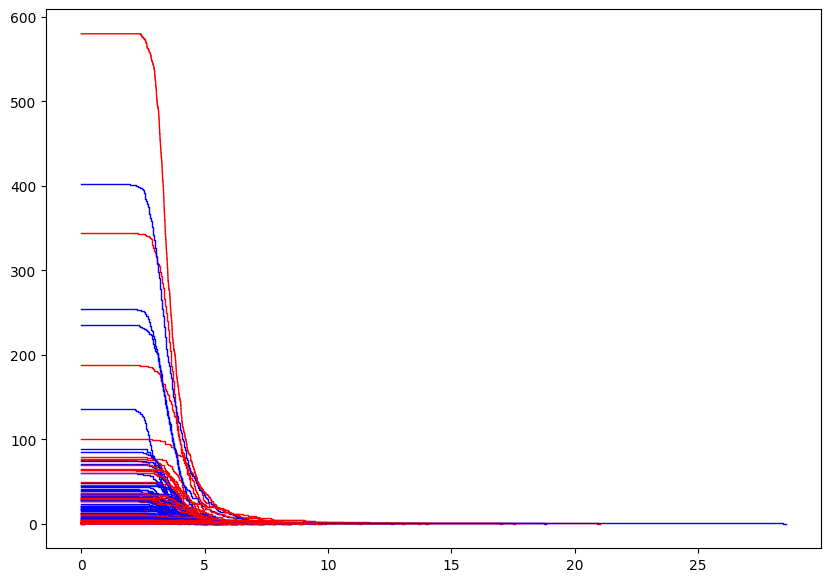

In [121]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["single"]):
    i = i[1]
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=1)

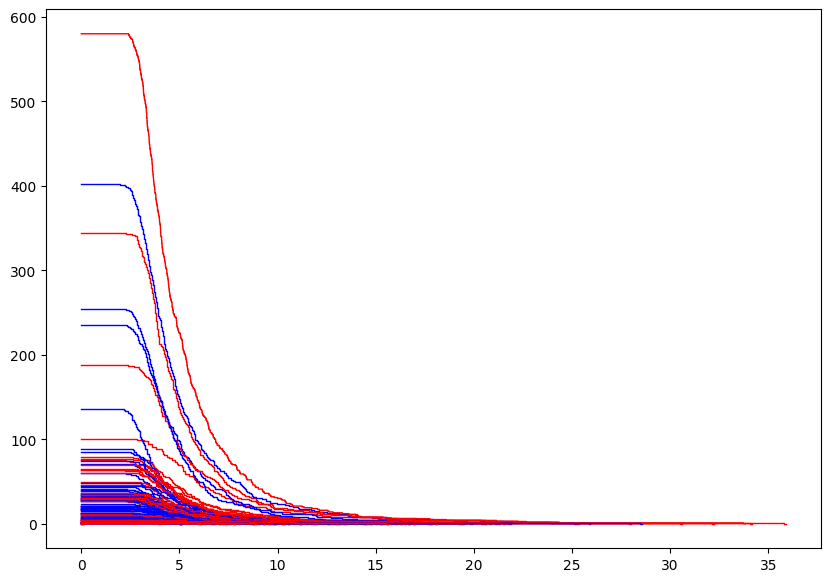

In [122]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["complete"]):
    i = i[1]
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=1)

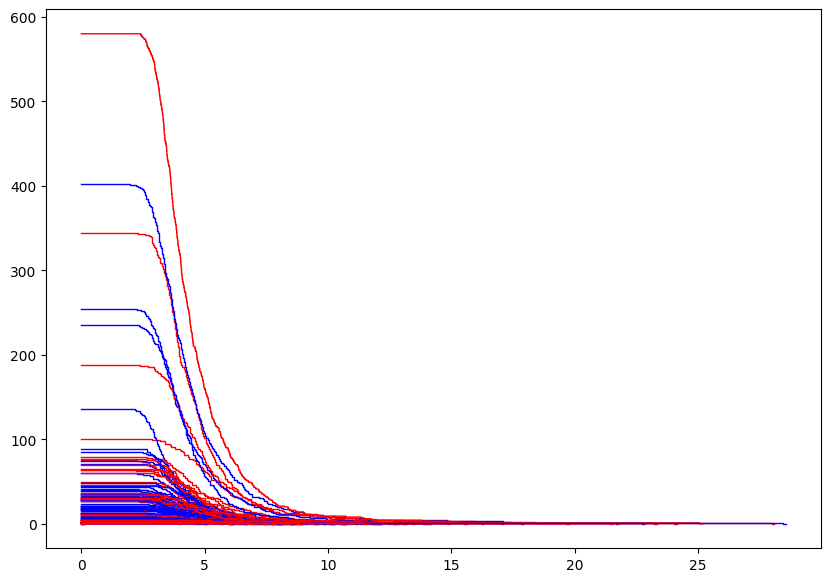

In [123]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["average"]):
    i = i[1]
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=1)

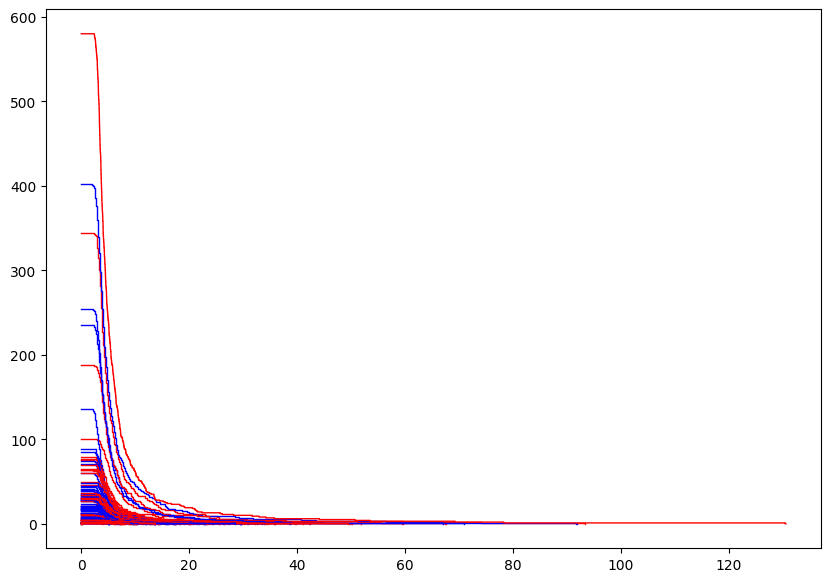

In [124]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["ward"]):
    i = i[1]
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=1)

In [109]:
prediction = {}
a_score = {}
for cm in clustering_methods:
    param_grid = {
    "C": np.linspace(0.01,0.2,20),
    }
    svc = SVC(kernel='precomputed')
    search = GridSearchCV(svc, param_grid, n_jobs=2, verbose = 1)
    search.fit(h0_kernel_train[cm], X_train.index.unique().get_level_values(0))
    #search.fit(h1_kernel_train[cm], X_train.index.unique().get_level_values(0))
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    prediction[cm] = search.predict(h0_kernel_test[cm])
    #prediction[cm] = search.predict(h1_kernel_test[cm])
    a_score[cm] = accuracy_score(X_test.index.unique().get_level_values(0), prediction[cm])
    print(cm+": ", a_score[cm])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter (CV score=0.682):
{'C': 0.01}
single:  0.45
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter (CV score=0.708):
{'C': 0.03}
complete:  0.54
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter (CV score=0.699):
{'C': 0.03}
average:  0.54
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameter (CV score=0.715):
{'C': 0.03}
ward:  0.54


In [18]:
# We need point clouds rather than individual vectors
# This is done in two steps:
# 1) Group by the region type (rural, non central population hub, central population hub)
X.index.get_level_values(0)
X['RURAL'] =(X.index.get_level_values(0).str[4] == 'A')*1
X['NON_CENTRAL_POP_HUB'] = (X.index.get_level_values(0).str[4] == 'B')*1
X['CENTRAL_POP_HUB'] = (X.index.get_level_values(0).str[4] == 'C')*1

In [39]:
# Let us first examine if there is differences between these region types
demography_distances = {}
demography_distributions = {}
demography_probabilities = {}
number_instances=300
sample_size=30
h0_sr = {}
h1_sr = {}
start = timer()    
#for region_type in ['RURAL', 'NON_CENTRAL_POP_HUB', 'CENTRAL_POP_HUB']:
for region_type in ['RURAL']:
    X_ = X.loc[X[region_type] == 1].copy()
    distance_ = sr.Distance(spatial.distance.pdist(X_, "euclidean"))
    distance_square = distance_.square_form()
    demography_distances[region_type] = distance_
    distributions_ = {}
    distributions_["0_15"] = sr.get_distribution(name="uniform", interval=[0,15])
    distributions_["5_20"] = sr.get_distribution(name="uniform", interval=[5,20])
    distributions_["10_25"] = sr.get_distribution(name="uniform", interval=[10,25])
    distributions_["10_30"] = sr.get_distribution(name="uniform", interval=[10,30])
    distributions_["15_35"] = sr.get_distribution(name="uniform", interval=[15,35])
    probabilities_ = {}
    demography_distributions[region_type] = distributions_
    for k in distributions_.keys():
        probabilities_[k] = distributions_[k](distance_square)
    demography_probabilities[region_type] = probabilities_
    for k in distributions_.keys():
        h0_sr[k] = []
        h1_sr[k] = []
        for d_ in distance_square:
            p = distributions_[k](d_)
            s = sr.get_sample(number_instances, sample_size, p)
            f = distance_.get_h0sr(sample=s,clustering_method="complete")
            b = distance_.get_bc(sample=s, maxdim=1)
            g = sr.bc_to_sr(b,degree="H1")
            h0_sr[k].append(f)
            h1_sr[k].append(g)
end = timer()
print(timedelta(seconds=end-start))                      

0:16:55.379863


In [57]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["single"]):
    i = i[0][:-2]
    print(i)
    if i == 'S':
        color = "orangered"
    elif i == 'SD':
        color = "yellow"
    elif i == 'M':
        color = "deepskyblue"
    elif i == 'V':
        color = "firebrick"
    elif i == 'KD':
        color = "darkblue"
    elif i == 'MP':
        color = "green"
    # if i == 'TEAM_UFFE':
    #     color = 'blue'
    # elif i == 'TEAM_MAGDA':
    #     color = 'red'
    f.plot(color=color, linewidth=2)

1764C10


NameError: name 'color' is not defined

<Figure size 1000x700 with 0 Axes>

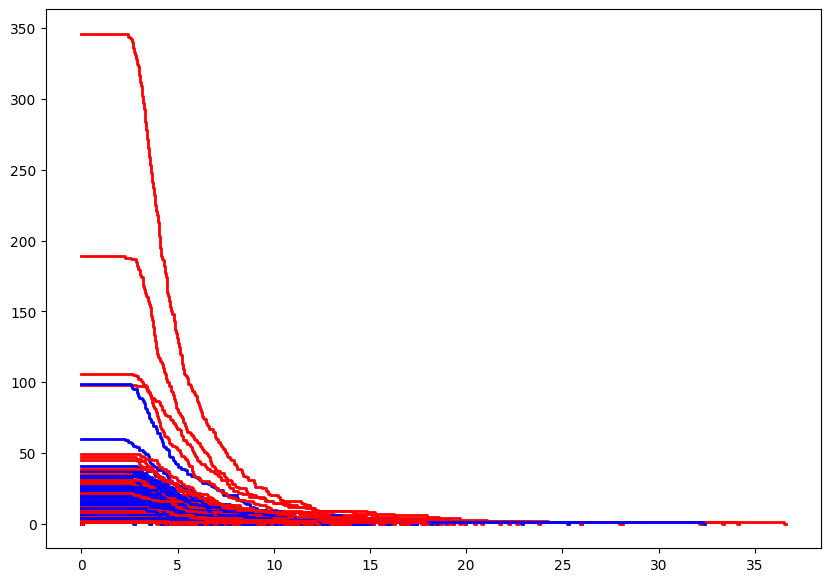

In [88]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["complete"]):
    i = i[0]
    # if i == 'S':
    #     color = "orangered"
    # elif i == 'SD':
    #     color = "yellow"
    # elif i == 'M':
    #     color = "deepskyblue"
    # elif i == 'V':
    #     color = "firebrick"
    # elif i == 'KD':
    #     color = "darkblue"
    # elif i == 'MP':
    #     color = "green"
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=2)

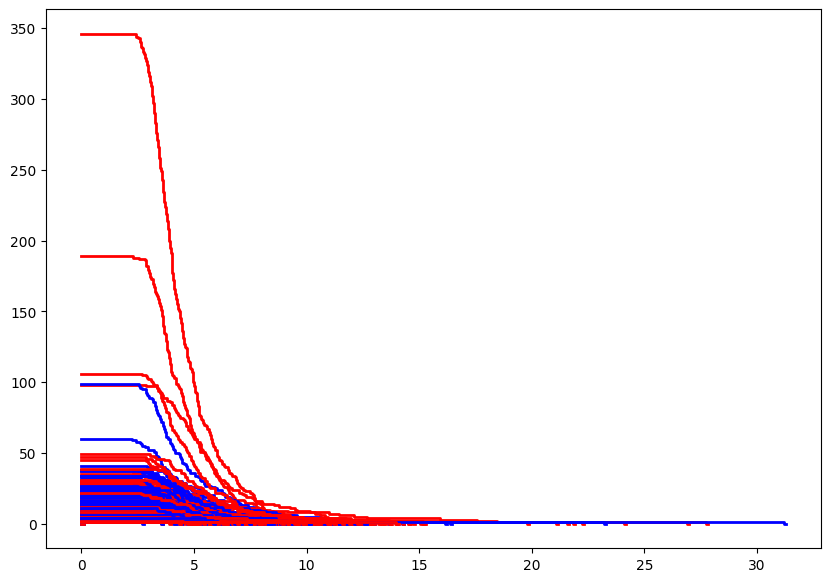

In [89]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["average"]):
    i = i[0]
    # if i == 'S':
    #     color = "orangered"
    # elif i == 'SD':
    #     color = "yellow"
    # elif i == 'M':
    #     color = "deepskyblue"
    # elif i == 'V':
    #     color = "firebrick"
    # elif i == 'KD':
    #     color = "darkblue"
    # elif i == 'MP':
    #     color = "green"
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=2)

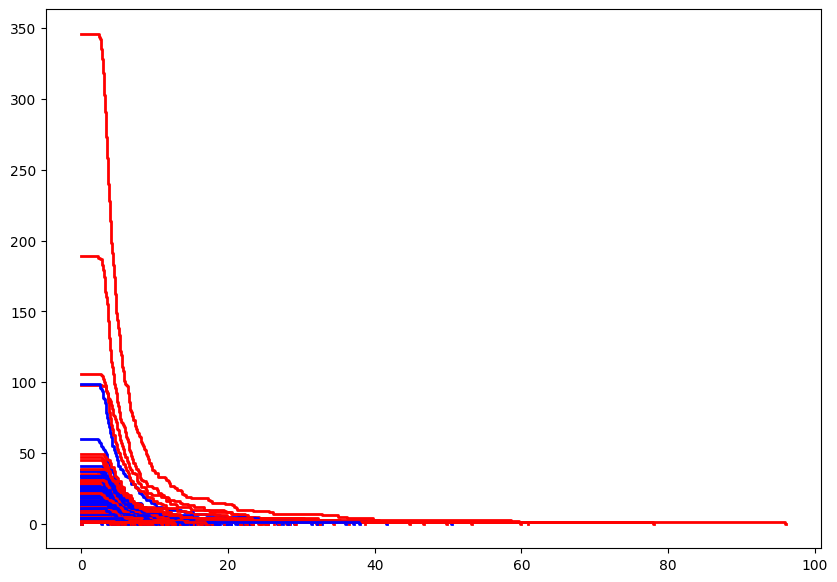

In [90]:
plt.figure(figsize=(10,7))
for i,f in zip(X_train.index.unique(), train_h0sr["ward"]):
    i = i[0]
    # if i == 'S':
    #     color = "orangered"
    # elif i == 'SD':
    #     color = "yellow"
    # elif i == 'M':
    #     color = "deepskyblue"
    # elif i == 'V':
    #     color = "firebrick"
    # elif i == 'KD':
    #     color = "darkblue"
    # elif i == 'MP':
    #     color = "green"
    if i == 'TEAM_UFFE':
        color = 'blue'
    elif i == 'TEAM_MAGDA':
        color = 'red'
    f.plot(color=color, linewidth=2)